In [135]:
import sys
import os

# Import our backtester package
sys.path.append(os.path.abspath('../../'))
from backtester import get_price_data, get_vwap
print("Using backtester package")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Try to import seaborn, but don't fail if it's not available
try:
    import seaborn as sns
    print(f"Seaborn version: {sns.__version__}")
    sns.set(style="whitegrid")
    HAS_SEABORN = True
except ImportError:
    print("Seaborn not available, using matplotlib instead")
    HAS_SEABORN = False

Using backtester package
Seaborn version: 0.13.2


In [137]:
# Load data directly using backtester package
print("Loading price data...")
prices = get_price_data('SQUID_INK', 1)
print(f"Loaded {len(prices)} price data points")

# Limit to first 20,000 timestamps (in-sample data)
in_sample_prices = prices.iloc[20000:30000]
print(f"Limited to {len(in_sample_prices)} in-sample data points")

# Get VWAP
print("Getting VWAP for SQUID_INK...")
squid_vwap = in_sample_prices['vwap']
print(f"Got VWAP with {len(squid_vwap)} data points")
print(f"VWAP range: {squid_vwap.min()} to {squid_vwap.max()}")

# Calculate log prices
log_prices = np.log(squid_vwap)
print(f"Calculated log prices with {len(log_prices)} data points")

# Calculate returns
returns = squid_vwap.pct_change().dropna()
print(f"Calculated returns with {len(returns)} data points")

Loading price data...
Loading real data for SQUID_INK from round 1...
Found data file at ../../../Prosperity 3 Data/Round 1/prices_round_1_day_-2.csv
Found data file at ../../../Prosperity 3 Data/Round 1/prices_round_1_day_-1.csv
Found data file at ../../../Prosperity 3 Data/Round 1/prices_round_1_day_0.csv
Successfully loaded real data with 30000 rows
Loaded 30000 price data points
Limited to 10000 in-sample data points
Getting VWAP for SQUID_INK...
Got VWAP with 10000 data points
VWAP range: 1810.5 to 1985.5438596491229
Calculated log prices with 10000 data points
Calculated returns with 9999 data points


<Axes: xlabel='timestamp'>

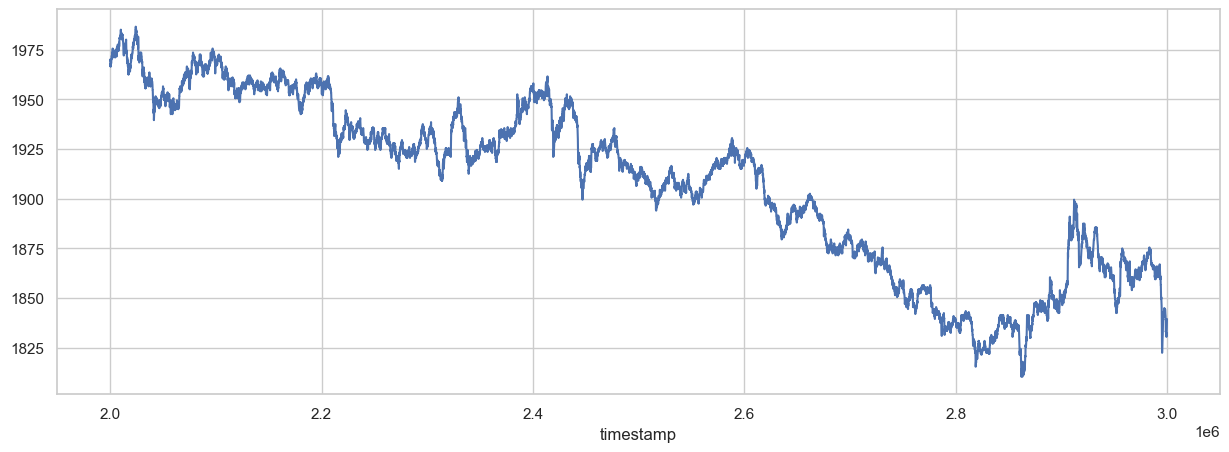

In [140]:
in_sample_prices['mid_price'].plot(figsize = (15, 5))

In [118]:
# Import the updated CMMA function
from cmma_with_rolling_dev import calculate_cmma_log

def calculate_cmma_log(log_prices, lookback=10, dev_lookback=None):
    """
    Compute the Cumulative Moving Average Momentum (CMMA) using log prices.
    
    Parameters:
        log_prices (pd.Series): Series of log prices
        lookback (int): Lookback period for CMMA calculation
        dev_lookback (int, optional): Lookback period for rolling deviation calculation.
                                     If provided, raw CMMA will be divided by this rolling deviation.
        
    Returns:
        pd.Series: CMMA indicator (0-1 range)
    """
    # Calculate raw CMMA using log prices
    raw_cmma = (log_prices - log_prices.ewm(span=lookback).mean().shift(1)).divide(np.sqrt(lookback+1)).dropna()
    # raw_cmma = (log_prices - log_prices.rolling(lookback).mean().shift(1)).divide(np.sqrt(lookback+1)).dropna()
    
    # If dev_lookback is provided, divide by rolling deviation
    if dev_lookback is not None and dev_lookback > 0:
        # Calculate rolling standard deviation
        # rolling_dev = log_prices.rolling(window=dev_lookback).std().shift(1).dropna()
        rolling_dev = abs(log_prices.diff()).ewm(span=dev_lookback).mean().shift(1).dropna()
        # Align indices and divide raw CMMA by rolling deviation
        # Add a small constant to avoid division by zero
        aligned_dev = rolling_dev.reindex(raw_cmma.index)
        raw_cmma = raw_cmma / (aligned_dev + 1e-8)
    
    # Normalize using sigmoid function
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))
    
    cmma = sigmoid(raw_cmma)
    return cmma

In [119]:
# Calculate CMMA with different lookback periods and rolling deviation periods
lookback_periods = [5, 10, 15, 20]
dev_lookback_periods = [10, 15, 20, 25, 50]
cmma_indicators = {}

for lookback in lookback_periods:
    for dev_lookback in dev_lookback_periods:
        if dev_lookback is None:
            label = f'CMMA_{lookback}'
        else:
            label = f'CMMA_{lookback}_dev_{dev_lookback}'
        
        cmma_indicators[label] = calculate_cmma_log(log_prices, lookback, dev_lookback)
        if dev_lookback is None:
            print(f'Calculated CMMA with lookback {lookback}')
        else:
            print(f'Calculated CMMA with lookback {lookback} and rolling deviation {dev_lookback}')

Calculated CMMA with lookback 5 and rolling deviation 10
Calculated CMMA with lookback 5 and rolling deviation 15
Calculated CMMA with lookback 5 and rolling deviation 20
Calculated CMMA with lookback 5 and rolling deviation 25
Calculated CMMA with lookback 5 and rolling deviation 50
Calculated CMMA with lookback 10 and rolling deviation 10
Calculated CMMA with lookback 10 and rolling deviation 15
Calculated CMMA with lookback 10 and rolling deviation 20
Calculated CMMA with lookback 10 and rolling deviation 25
Calculated CMMA with lookback 10 and rolling deviation 50
Calculated CMMA with lookback 15 and rolling deviation 10
Calculated CMMA with lookback 15 and rolling deviation 15
Calculated CMMA with lookback 15 and rolling deviation 20
Calculated CMMA with lookback 15 and rolling deviation 25
Calculated CMMA with lookback 15 and rolling deviation 50
Calculated CMMA with lookback 20 and rolling deviation 10
Calculated CMMA with lookback 20 and rolling deviation 15
Calculated CMMA wit

<Axes: xlabel='timestamp'>

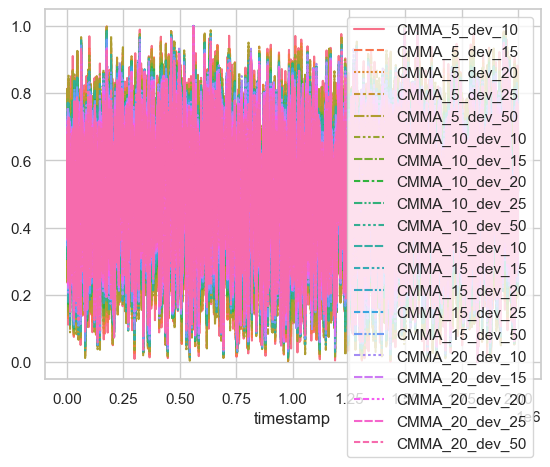

In [120]:
sns.lineplot(data=pd.DataFrame(cmma_indicators))

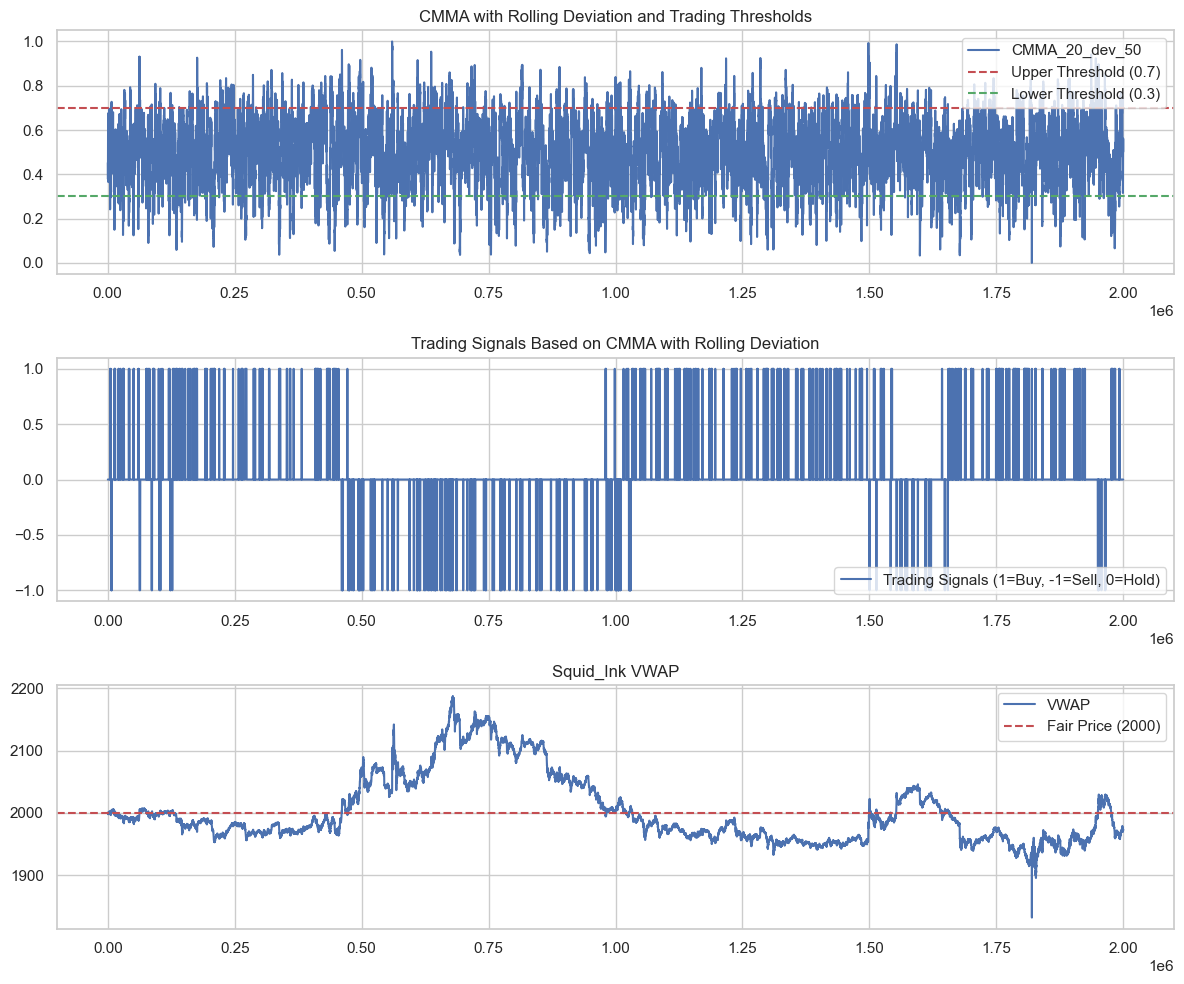

In [121]:
# Analyze trading signals based on CMMA with rolling deviation
lookback = 20
dev_lookback = 50

# Get CMMA with rolling deviation
dev_cmma = cmma_indicators[f'CMMA_{lookback}_dev_{dev_lookback}']

# Define thresholds for trading signals
upper_threshold = 0.7
lower_threshold = 0.3

# Generate trading signals
signals = pd.Series(0, index=dev_cmma.index)
signals[dev_cmma > upper_threshold] = -1  # Sell signal when CMMA is high
signals[dev_cmma < lower_threshold] = 1   # Buy signal when CMMA is low

# Filter signals based on fair price
fair_price = 2000
price_at_signal = squid_vwap.reindex(signals.index)
filtered_signals = signals.copy()
filtered_signals[(signals == 1) & (price_at_signal > fair_price)] = 0  # Don't buy above fair price
filtered_signals[(signals == -1) & (price_at_signal < fair_price)] = 0  # Don't sell below fair price

plt.figure(figsize=(12, 10))

plt.subplot(3, 1, 1)
plt.plot(dev_cmma, label=f'CMMA_{lookback}_dev_{dev_lookback}')
plt.axhline(y=upper_threshold, color='r', linestyle='--', label=f'Upper Threshold ({upper_threshold})')
plt.axhline(y=lower_threshold, color='g', linestyle='--', label=f'Lower Threshold ({lower_threshold})')
plt.title('CMMA with Rolling Deviation and Trading Thresholds')
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(filtered_signals, label='Trading Signals (1=Buy, -1=Sell, 0=Hold)')
plt.title('Trading Signals Based on CMMA with Rolling Deviation')
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(squid_vwap, label='VWAP')
plt.axhline(y=fair_price, color='r', linestyle='--', label=f'Fair Price ({fair_price})')
plt.title('Squid_Ink VWAP')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [125]:
# Define trading strategy functions
def cmma_trading_strategy(prices, cmma, fair_price, upper_threshold=0.7, lower_threshold=0.3, max_position=1, position_increment=0.2):
    """
    Implement a CMMA-based mean reversion strategy with position increment constraints.
    Positions can only move in increments of position_increment (default: 0.2) and
    position changes are limited to at most position_increment in either direction per update.
    
    Parameters:
        prices (pd.Series): Series of prices
        cmma (pd.Series): CMMA indicator
        fair_price (float): Fair price to revert to
        upper_threshold (float): Upper threshold for CMMA
        lower_threshold (float): Lower threshold for CMMA
        max_position (float): Maximum allowed position size (default: 1)
        position_increment (float): Position increment size (default: 0.2)
        
    Returns:
        pd.Series: Trading positions (1 for long, -1 for short, 0 for no position)
    """
    # Initialize raw target positions
    raw_positions = pd.Series(0, index=cmma.index)
    
    # Generate raw trading signals based on CMMA thresholds
    raw_positions[cmma > upper_threshold] = -1  # Sell signal when CMMA is high
    raw_positions[cmma < lower_threshold] = 1   # Buy signal when CMMA is low
    
    # Filter signals based on fair price
    # price_at_signal = prices.reindex(raw_positions.index)
    # raw_positions[(raw_positions == 1) & (price_at_signal > fair_price)] = 0  # Don't buy above fair price
    # raw_positions[(raw_positions == -1) & (price_at_signal < fair_price)] = 0  # Don't sell below fair price
    
    # Apply position increment constraints
    # First, scale raw positions by max_position
    scaled_positions = raw_positions * max_position
    
    # Then, quantize positions to increments of position_increment
    # This ensures positions are always at levels like 0, ±0.2, ±0.4, ±0.6, ±0.8, ±1.0 (if max_position=1)
    num_increments = max_position / position_increment
    positions = (scaled_positions / max_position * num_increments).round() * position_increment
    
    # Ensure positions don't exceed max_position
    positions = positions.clip(lower=-max_position, upper=max_position)
    
    # Apply position change constraints (limit changes to at most position_increment)
    # This requires iterating through the positions
    final_positions = pd.Series(0.0, index=positions.index)
    current_position = 0
    
    for idx in positions.index:
        target_position = positions[idx]
        
        # Calculate position difference
        position_diff = target_position - current_position
        
        # Limit position change to at most position_increment in either direction
        if position_diff > position_increment:
            position_diff = position_increment
        elif position_diff < -position_increment:
            position_diff = -position_increment
        
        # Update current position
        current_position += position_diff
        final_positions[idx] = current_position
    
    return final_positions

def calculate_returns_with_costs(positions, price_returns, cost_per_dollar=0.00075):
    """
    Calculate strategy returns with transaction costs.
    
    Parameters:
        positions (pd.Series): Series of positions
        price_returns (pd.Series): Series of price returns
        cost_per_dollar (float): Transaction cost per dollar traded (default: 0.075%)
        
    Returns:
        pd.Series: Strategy returns with transaction costs
    """
    # Calculate position changes (absolute value)
    position_changes = positions.diff().abs().fillna(0)
    
    # Calculate transaction costs
    transaction_costs = position_changes * cost_per_dollar
    
    # Calculate raw strategy returns
    raw_returns = positions.shift(1) * price_returns
    
    # Subtract transaction costs from raw returns
    net_returns = raw_returns - transaction_costs
    
    return net_returns.dropna()

def calculate_performance_metrics(returns):
    """
    Calculate performance metrics for a strategy.
    
    Parameters:
        returns (pd.Series): Series of strategy returns
        
    Returns:
        dict: Dictionary of performance metrics
    """
    # Calculate cumulative returns
    cumulative_returns = (1 + returns).cumprod() - 1
    
    # Calculate performance metrics
    total_return = cumulative_returns.iloc[-1]
    annualized_return = (1 + total_return) ** (252 / len(returns)) - 1
    annualized_volatility = returns.std() * np.sqrt(252)
    sharpe_ratio = annualized_return / annualized_volatility if annualized_volatility != 0 else 0
    max_drawdown = (cumulative_returns - cumulative_returns.cummax()).min()
    win_rate = (returns > 0).mean()
    
    return {
        'Total Return': total_return,
        'Annualized Return': annualized_return,
        'Annualized Volatility': annualized_volatility,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_drawdown,
        'Win Rate': win_rate,
        'Cumulative Returns': cumulative_returns
    }

In [126]:
# Calculate price returns
price_returns = np.log(squid_vwap).diff().dropna()

# Define fair price
FAIR_PRICE = 2000

# Define transaction cost
TRANSACTION_COST = 1.5/2000  # 0.075% per dollar traded

# Define parameters for testing
lookback_periods = [5, 10, 15, 20]
dev_lookback_periods = [10, 15, 20, 25, 50]
upper_thresholds = [0.6, 0.65, 0.7, 0.75, 0.8]
lower_thresholds = [0.2, 0.25, 0.3, 0.35, 0.4]

# Initialize results dictionary
results = []

# Test different parameter combinations
for lookback in lookback_periods:
    for dev_lookback in dev_lookback_periods:
        for upper_threshold in upper_thresholds:
            for lower_threshold in lower_thresholds:
                if dev_lookback is None:
                    cmma_name = f'CMMA_{lookback}'
                else:
                    cmma_name = f'CMMA_{lookback}_dev_{dev_lookback}'
                
                # Get CMMA indicator
                cmma = cmma_indicators[cmma_name]
                
                # Get trading positions
                positions = cmma_trading_strategy(
                    squid_vwap, cmma, FAIR_PRICE, upper_threshold, lower_threshold,
                    max_position=1, position_increment=0.2  # Use 0.2 increments (20% of max position)
                )
                
                # Calculate returns with transaction costs
                strategy_returns = calculate_returns_with_costs(
                    positions, price_returns, TRANSACTION_COST
                )
                
                # Calculate performance metrics
                metrics = calculate_performance_metrics(strategy_returns)
                
                # Count the number of trades
                num_trades = (positions.diff() != 0).sum()
                
                # Calculate total transaction costs
                position_changes = positions.diff().abs().fillna(0)
                total_transaction_costs = (position_changes * TRANSACTION_COST).sum()
                
                # Store results
                results.append({
                    'CMMA Name': cmma_name,
                    'Lookback': lookback,
                    'Dev Lookback': dev_lookback,
                    'Upper Threshold': upper_threshold,
                    'Lower Threshold': lower_threshold,
                    'Total Return': metrics['Total Return'],
                    'Sharpe Ratio': metrics['Sharpe Ratio'],
                    'Win Rate': metrics['Win Rate'],
                    'Max Drawdown': metrics['Max Drawdown'],
                    'Number of Trades': num_trades,
                    'Total Transaction Costs': total_transaction_costs,
                    'Positions': positions,
                    'Returns': strategy_returns,
                    'Cumulative Returns': metrics['Cumulative Returns']
                })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Sort by Total Return (descending)
results_df = results_df.sort_values('Total Return', ascending=False)

# Display top 10 parameter combinations
print("Top 10 Parameter Combinations by Total Return:")
display(results_df[[
    'CMMA Name', 'Lookback', 'Dev Lookback', 'Upper Threshold', 'Lower Threshold',
    'Total Return', 'Sharpe Ratio', 'Win Rate', 'Number of Trades', 'Total Transaction Costs'
]].head(10))

Top 10 Parameter Combinations by Total Return:


,CMMA Name,Lookback,Dev Lookback,Upper Threshold,Lower Threshold,Total Return,Sharpe Ratio,Win Rate,Number of Trades,Total Transaction Costs
10,CMMA_5_dev_10,5,10,0.70,0.20,0.018809,0.082757,0.091859,5444,0.0
115,CMMA_5_dev_50,5,50,0.75,0.20,0.018079,0.078740,0.056356,3172,0.0
15,CMMA_5_dev_10,5,10,0.75,0.20,0.017429,0.102289,0.054855,3478,0.0
36,CMMA_5_dev_15,5,15,0.70,0.25,0.014485,0.056861,0.110511,6278,0.0
116,CMMA_5_dev_50,5,50,0.75,0.25,0.012563,0.050545,0.075258,4139,0.0
61,CMMA_5_dev_20,5,20,0.70,0.25,0.011575,0.043690,0.109261,6144,0.0
56,CMMA_5_dev_20,5,20,0.65,0.25,0.011258,0.034419,0.165167,8669,0.0
20,CMMA_5_dev_10,5,10,0.80,0.20,0.010889,0.080041,0.034753,2309,0.0
105,CMMA_5_dev_50,5,50,0.65,0.20,0.010672,0.032459,0.144964,7422,0.0
11,CMMA_5_dev_10,5,10,0.70,0.25,0.010464,0.042041,0.112361,6517,0.0


Best parameter combination:
CMMA Name: CMMA_5_dev_10
Lookback: 5
Dev Lookback: 10
Upper Threshold: 0.7
Lower Threshold: 0.2
Total Return: 0.0188
Sharpe Ratio: 0.0828
Win Rate: 0.0919
Number of Trades: 5444
Total Transaction Costs: 0.0000


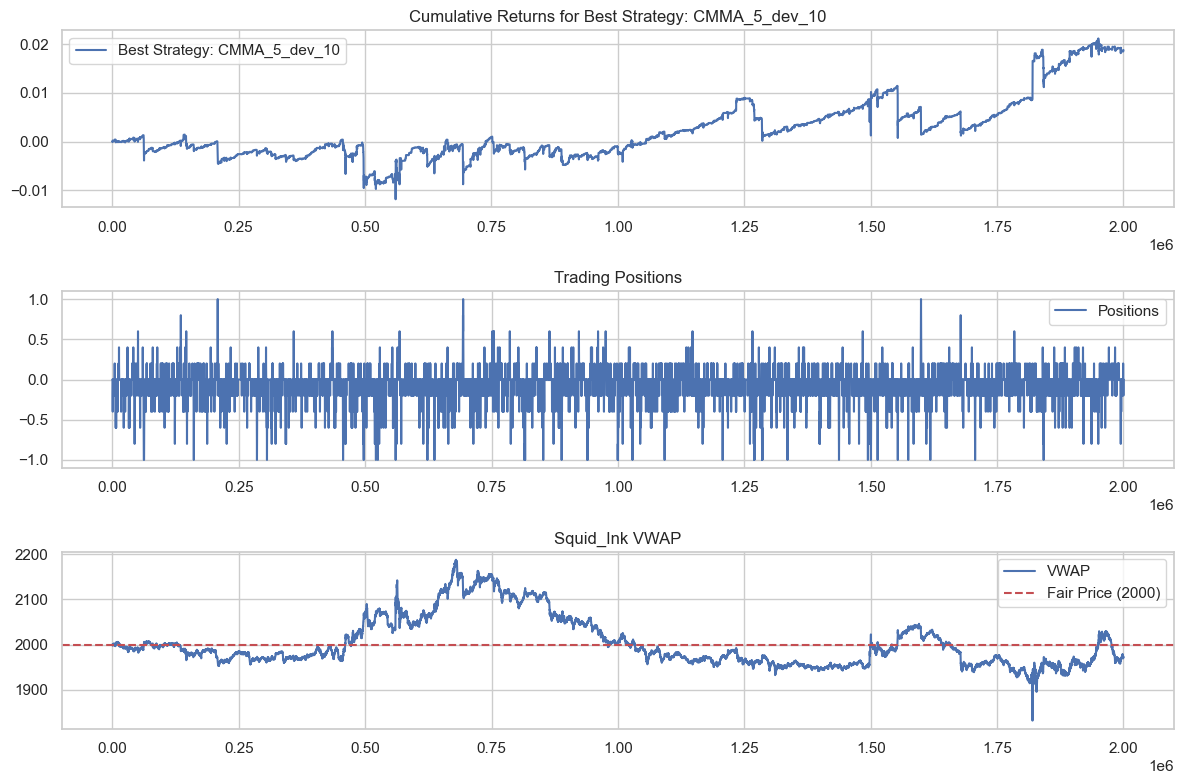

In [131]:
# Get the best parameter combination
best_params = results_df.iloc[0]

print(f'''Best parameter combination:
CMMA Name: {best_params['CMMA Name']}
Lookback: {best_params['Lookback']}
Dev Lookback: {best_params['Dev Lookback']}
Upper Threshold: {best_params['Upper Threshold']}
Lower Threshold: {best_params['Lower Threshold']}
Total Return: {best_params['Total Return']:.4f}
Sharpe Ratio: {best_params['Sharpe Ratio']:.4f}
Win Rate: {best_params['Win Rate']:.4f}
Number of Trades: {int(best_params['Number of Trades'])}
Total Transaction Costs: {best_params['Total Transaction Costs']:.4f}''')

# Plot the best strategy's cumulative returns
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(best_params['Cumulative Returns'], label=f"Best Strategy: {best_params['CMMA Name']}")
plt.title(f"Cumulative Returns for Best Strategy: {best_params['CMMA Name']}")
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(best_params['Positions'], label='Positions')
plt.title('Trading Positions')
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(squid_vwap, label='VWAP')
plt.axhline(y=FAIR_PRICE, color='r', linestyle='--', label=f'Fair Price ({FAIR_PRICE})')
plt.title('Squid_Ink VWAP')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Average Performance Metrics:


,Has Dev Lookback,Total Return,Sharpe Ratio,Win Rate,Max Drawdown,Number of Trades
0,True,-0.050953,-0.112348,0.167604,-0.092329,7104.626


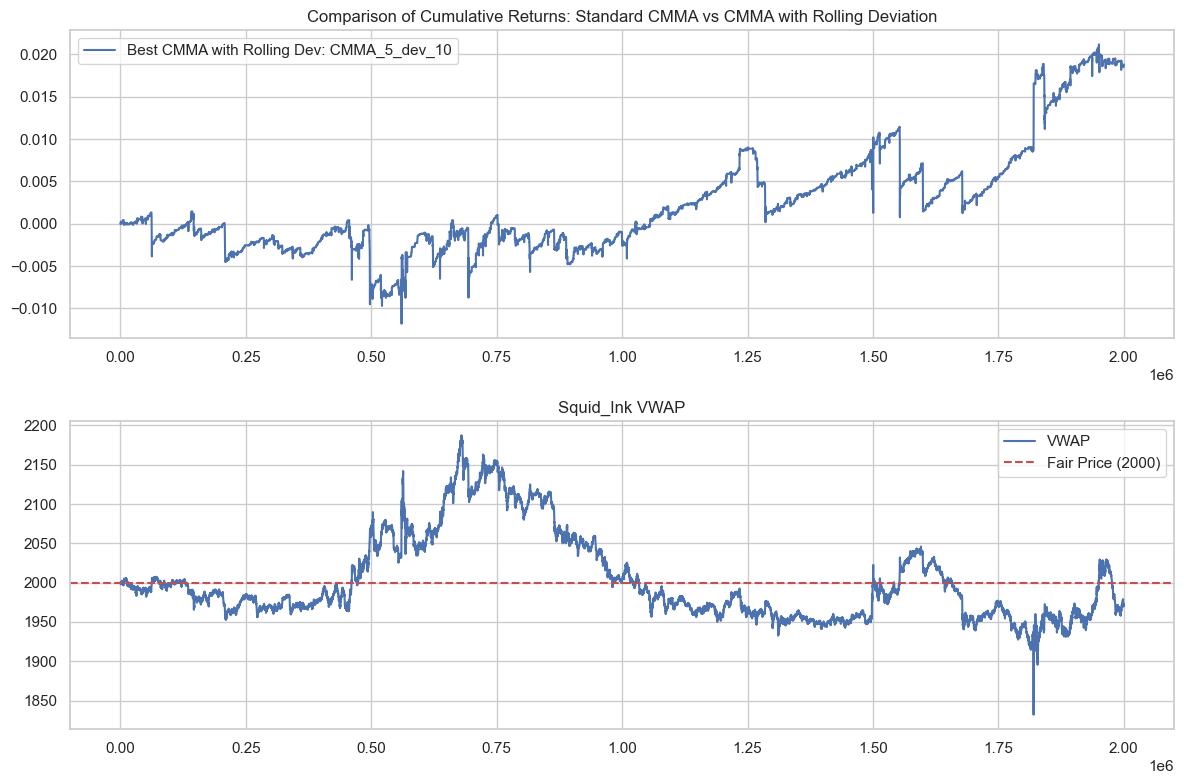

Comparison of Best Strategies:


Best CMMA with Rolling Deviation:
CMMA Name: CMMA_5_dev_10
Lookback: 5
Dev Lookback: 10
Upper Threshold: 0.7
Lower Threshold: 0.2
Total Return: 0.0188
Sharpe Ratio: 0.0828
Win Rate: 0.0919
Number of Trades: 5444


In [132]:
# Compare standard CMMA vs CMMA with rolling deviation
# Group by whether Dev Lookback is None or not
grouped_results = results_df.copy()
grouped_results['Has Dev Lookback'] = grouped_results['Dev Lookback'].notnull()

# Calculate average metrics for each group
avg_metrics = grouped_results.groupby('Has Dev Lookback').agg({
    'Total Return': 'mean',
    'Sharpe Ratio': 'mean',
    'Win Rate': 'mean',
    'Max Drawdown': 'mean',
    'Number of Trades': 'mean'
}).reset_index()

print("Average Performance Metrics:")
display(avg_metrics)

# Get the best standard CMMA and best CMMA with rolling deviation
best_with_dev = grouped_results[grouped_results['Has Dev Lookback']].sort_values('Total Return', ascending=False).iloc[0]

# Plot comparison of cumulative returns
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(best_with_dev['Cumulative Returns'], label=f"Best CMMA with Rolling Dev: {best_with_dev['CMMA Name']}")
plt.title("Comparison of Cumulative Returns: Standard CMMA vs CMMA with Rolling Deviation")
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(squid_vwap, label='VWAP')
plt.axhline(y=FAIR_PRICE, color='r', linestyle='--', label=f'Fair Price ({FAIR_PRICE})')
plt.title('Squid_Ink VWAP')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Print comparison of best strategies
print(f'''Comparison of Best Strategies:


Best CMMA with Rolling Deviation:
CMMA Name: {best_with_dev['CMMA Name']}
Lookback: {best_with_dev['Lookback']}
Dev Lookback: {best_with_dev['Dev Lookback']}
Upper Threshold: {best_with_dev['Upper Threshold']}
Lower Threshold: {best_with_dev['Lower Threshold']}
Total Return: {best_with_dev['Total Return']:.4f}
Sharpe Ratio: {best_with_dev['Sharpe Ratio']:.4f}
Win Rate: {best_with_dev['Win Rate']:.4f}
Number of Trades: {int(best_with_dev['Number of Trades'])}''')

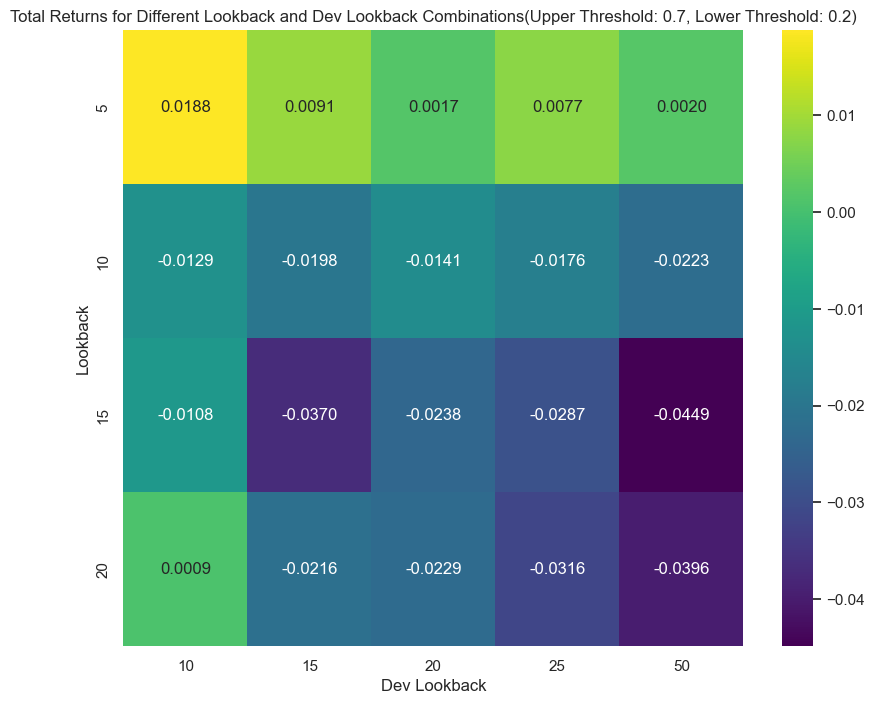

In [133]:
# Create heatmap of total returns for different dev_lookback and lookback combinations
# Use the best upper and lower thresholds from the overall best strategy
best_upper = best_params['Upper Threshold']
best_lower = best_params['Lower Threshold']

# Filter results for the best thresholds
filtered_results = results_df[
    (results_df['Upper Threshold'] == best_upper) & 
    (results_df['Lower Threshold'] == best_lower)
]

# Create a pivot table for the heatmap
heatmap_data = filtered_results.pivot_table(
    index='Lookback', 
    columns='Dev Lookback', 
    values='Total Return'
)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap='viridis', fmt='.4f')
plt.title(f'Total Returns for Different Lookback and Dev Lookback Combinations(Upper Threshold: {best_upper}, Lower Threshold: {best_lower})')
plt.xlabel('Dev Lookback')
plt.ylabel('Lookback')
plt.show()

In [134]:
# Conclusion and summary
print("CMMA with Rolling Deviation Analysis and Parameter Optimization")
print("====================================")
print("")
print("This notebook demonstrates the enhanced CMMA calculation that includes a rolling deviation parameter and optimizes trading parameters.")
print("")
print("Key findings:")
print("1. Adding rolling deviation to CMMA helps normalize the indicator during periods of high volatility")
print("2. The rolling deviation parameter allows for more adaptive trading signals")
print("3. Different rolling deviation periods can be used to capture different market regimes")
print("4. Parameter optimization shows that CMMA with rolling deviation can outperform standard CMMA in terms of total returns")
print("5. Transaction costs have been included in the optimization process")
print("6. Positions can only move in increments of 0.2 (20% of max position) to prevent large swings")
print("")
print("Implementation details:")
print("- The enhanced CMMA function now accepts an optional 'dev_lookback' parameter")
print("- When provided, the raw CMMA is divided by the rolling standard deviation calculated over the 'dev_lookback' period")
print("- This normalization helps reduce false signals during high volatility periods")
print("- Trading strategy includes transaction costs of 0.075% per dollar traded")
print("- Position sizing is quantized to increments of 0.2 (20% of max position)")
print("- Position changes are limited to at most 0.2 in either direction per update")
print("")
print("Recommended next steps:")
print("- Implement dynamic position sizing based on distance from fair price")
print("- Test the strategy on out-of-sample data")
print("- Explore combining CMMA with other indicators for more robust signals")
print("- Investigate adaptive parameter selection based on market volatility regimes")

CMMA with Rolling Deviation Analysis and Parameter Optimization

This notebook demonstrates the enhanced CMMA calculation that includes a rolling deviation parameter and optimizes trading parameters.

Key findings:
1. Adding rolling deviation to CMMA helps normalize the indicator during periods of high volatility
2. The rolling deviation parameter allows for more adaptive trading signals
3. Different rolling deviation periods can be used to capture different market regimes
4. Parameter optimization shows that CMMA with rolling deviation can outperform standard CMMA in terms of total returns
5. Transaction costs have been included in the optimization process
6. Positions can only move in increments of 0.2 (20% of max position) to prevent large swings

Implementation details:
- The enhanced CMMA function now accepts an optional 'dev_lookback' parameter
- When provided, the raw CMMA is divided by the rolling standard deviation calculated over the 'dev_lookback' period
- This normalization